# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from ekphrasis.classes.segmenter import Segmenter
seg = Segmenter(corpus="twitter") 

Reading twitter - 1grams ...
Reading twitter - 2grams ...


# Data Processing

In [4]:
# Read Data
NYX = pd.read_csv("NYX2019.csv", sep = "\t", usecols = ["language","tweet"])
REVLON = pd.read_csv("REVLON2019.csv", sep = "\t", usecols = ["language","tweet"])
WETNWILD = pd.read_csv("WETNWILD2019.csv", sep = "\t", usecols = ["language","tweet"])

In [5]:
# Keep only English rows
NYX = NYX[NYX["language"]=="en"]
NYX.index=range(len(NYX))

REVLON = REVLON[REVLON["language"]=="en"]
REVLON.index=range(len(REVLON))

WETNWILD = WETNWILD[WETNWILD["language"]=="en"]
WETNWILD.index=range(len(WETNWILD))

In [6]:
## Preprocessing
def textPreprocessing(text) :
    
    # to lower case
    text = text.lower()
    
    # delete url
    text = re.sub(r"(https?|ftp|file)://[-A-Za-z0-9+&@#/%?=~_|!:,.;]+[-A-Za-z0-9+&@#/%=~_|]","",text)
    
    # delete all the non-English characters  
    res = re.compile("[^a-z^A-Z^0-9]")
    text = res.sub(r" ", text)
    
    # tokenize
    text = nltk.word_tokenize(text)
    
    # word segmentation
    exception = ["makeupforever", "anatasiabeverlyhills", "nyx"]
    tweet_processed_list = [seg.segment(word) for word in text if word not in exception]
    
    # delete stopwords
    filtered = [w for w in text if w not in stopwords.words('english')]
    
    # stemmisation (remove for now)
    # ps = PorterStemmer()
    # filtered = [ps.stem(w) for w in filtered]
    
    # lemmanisation
    lemmatizer = nltk.stem.WordNetLemmatizer()
    filtered = [lemmatizer.lemmatize(w) for w in filtered]
    
    # only use NN to keep nouns
    refiltered = nltk.pos_tag(filtered)
    filtered = [w for w, pos in refiltered if pos.startswith('NN')]

    return " ".join(filtered)

In [7]:
# Construct a word list for each brand

NYX_list = []
for i in range(0, len(NYX)):
    NYX_list.append(textPreprocessing(NYX["tweet"][i]))
NYX_doc = " ".join(NYX_list)

REVLON_list = []
for i in range(0, len(REVLON)):
    REVLON_list.append(textPreprocessing(REVLON["tweet"][i]))
REVLON_doc = " ".join(REVLON_list)
   
WETNWILD_list = []
for i in range(0, len(WETNWILD)):
    WETNWILD_list.append(textPreprocessing(WETNWILD["tweet"][i]))
WETNWILD_doc = " ".join(WETNWILD_list)

In [8]:
# # Construct a doc list containing word lists of all brands
# # 16766 sub-lists, each list containing word lists of each tweet

doc_list=[]
# #doc_list.append(NYX_doc)
# #doc_list.append(REVLON_doc)
# #doc_list.append(WETNWILD_doc)
doc_list += (NYX_list)
doc_list += (REVLON_list)
doc_list += (WETNWILD_list)

In [9]:
# Create the Document-Word matrix

from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.externals import joblib  

# API: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2,          # minimum reqd occurences of a word
                                max_features=2000,  # max number of uniq words
                                stop_words='english')

#joblib.dump(tf_vectorizer, './vectorizer_sklearn.model')
#tf_vectorizer = joblib.load('./vectorizer_sklearn.model')

tf = tf_vectorizer.fit_transform(doc_list)

#print(tf)

In [10]:
# Materialize the sparse data
data_dense = tf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.3390969819873554 %


In [11]:
# LDA training
# API: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 8

lda = LatentDirichletAllocation(n_components=n_topics,    # number of topics
                                max_iter=1,
                                learning_method='online', # set 'online' because faster for large dataset
                                verbose=True, 
                                n_jobs = -1               # use all available CPUs
                               )
lda.fit(tf)  # tf is Document_word Sparse Matrix

#joblib.dump(lda, './LDA_sklearn_main.model')
# lda = joblib.load('./LDA_sklearn_main.model')

#print(lda.perplexity(tf))

iteration: 1 of max_iter: 1


LatentDirichletAllocation(learning_method='online', max_iter=1, n_components=8,
                          n_jobs=-1, verbose=True)

## The dominant topic in each document

In [12]:
lda_output = lda.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(n_topics)]
# index names
# docnames = ["NYX","REVLON","WETNWILD"]
docnames = ["Doc" + str(i) for i in range(len(doc_list))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,dominant_topic
Doc0,0.870000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0
Doc1,0.020000,0.020000,0.140000,0.020000,0.200000,0.020000,0.370000,0.220000,6
Doc2,0.020000,0.020000,0.020000,0.020000,0.850000,0.020000,0.020000,0.020000,4
Doc3,0.570000,0.010000,0.010000,0.010000,0.010000,0.010000,0.380000,0.010000,0
Doc4,0.030000,0.030000,0.780000,0.030000,0.030000,0.030000,0.030000,0.030000,2
Doc5,0.010000,0.930000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,1
Doc6,0.010000,0.010000,0.010000,0.010000,0.910000,0.010000,0.010000,0.010000,4
Doc7,0.010000,0.010000,0.010000,0.910000,0.010000,0.010000,0.010000,0.010000,3
Doc8,0.560000,0.030000,0.030000,0.030000,0.030000,0.290000,0.030000,0.030000,0
Doc9,0.010000,0.010000,0.010000,0.010000,0.250000,0.460000,0.240000,0.010000,5


In [13]:
# Plotting tools
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

C:\Users\irabe\.conda\envs\venv\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
C:\Users\irabe\.conda\envs\venv\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
C:\Users\irabe\.conda\envs\venv\lib\site-packages\funcy\colls.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, Set, Iterable, Iterator, defaultdict
C:\Users\irabe\.conda\envs\venv\lib\site-packages\funcy\colls.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead o

In [14]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel

C:\Users\irabe\.conda\envs\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
6     -108.958252 -208.941483       1        1  21.397695
5      186.487061  -98.103249       2        1  17.981879
4       19.245832  160.858780       3        1  17.454992
2      170.658829   75.445076       4        1  11.267710
0       -1.386411  -35.043739       5        1  10.402928
3     -145.800095  106.944611       6        1   7.730587
1       64.834541 -221.825272       7        1   7.018631
7     -196.906036  -58.990913       8        1   6.745579, topic_info=              Term         Freq        Total Category  logprob  loglift
1938      wetnwild  5248.000000  5248.000000  Default  30.0000  30.0000
1524        revlon  4599.000000  4599.000000  Default  29.0000  29.0000
1936           wet  2144.000000  2144.000000  Default  28.0000  28.0000
547           ebay  2912.000000  2912.000000  Default  27.0000  27.0000
313          check  2734.000000  2734.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
1578          sale   108.494708   147.405429   Topic8  -4.3216   2.3898
190           blue    67.535602    89.833161   Topic8  -4.7956   2.4110
1048  maccosmetics    84.913006   237.487437   Topic8  -4.5666   1.6678
1992       youtube    92.075872   332.761469   Topic8  -4.4856   1.4115
1821         today    65.963537   622.967711   Topic8  -4.8192   0.4509

[386 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
4         1  0.986122  abhcosmetics
4         5  0.006994  abhcosmetics
11        2  0.986215            ad
23        7  0.990567           air
37        1  0.474761           amp
...     ...       ...           ...
1984      7  0.619042          year
1986      1  0.988932     yesterday
1988      3  0.981254      younique
1992      2  0.721237       youtube
1992      8  0.276474       youtube

[540 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 5, 3, 1, 4, 2, 8])

## The Topic’s keywords

In [15]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda.components_)

# Assign Column and Index
df_topic_keywords.columns = tf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,a031,abercrombiefitch,abh,abhbrows,abhcosmetics,abhprsearch,accessory,account,accra,ace,...,youniquepresenter,youth,youtube,youtuber,youtubers,zara,zeus,zombie,zone,zulu
Topic0,34.377057,0.125204,1.256999,0.125341,1.908899,0.125359,0.125218,0.125235,1.208057,0.125226,...,0.125229,0.125295,0.125385,0.125395,0.129732,0.125247,0.125163,0.127582,0.143322,0.125471
Topic1,0.682987,0.125203,0.125229,0.125274,0.125270,0.125233,0.125214,0.125397,0.565896,0.125324,...,0.125291,0.125272,0.125351,0.125308,0.125182,0.125231,0.125295,0.125210,0.126689,0.125263
Topic2,0.125254,6.460889,0.125394,0.125235,0.125251,0.126908,0.129691,0.125432,3.160438,0.137506,...,0.147823,0.196561,0.272730,0.810242,0.139943,16.232772,0.881509,0.125273,0.125227,0.130423
Topic3,0.676134,0.137412,0.329141,0.192873,0.125354,0.128779,0.125652,0.128952,0.769010,8.755893,...,0.126041,14.898771,0.125472,0.125994,0.125566,0.125257,0.125219,0.125411,0.125450,0.125274
Topic4,0.125194,0.125211,0.125776,0.125265,0.163910,10.552959,0.126052,0.125919,3.306286,0.125226,...,20.072638,0.125266,0.131363,92.558248,0.126965,0.125256,0.132903,3.312642,41.718400,0.125224


In [16]:
# Get the top 15 keywords each topic
n_top_words = 15

def show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=n_top_words)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,wet,ebay,check,lot,coloricon,palette,shadow,megaglo,concealer,makeuplooks,summer,liner,c320,spring,medium
Topic 1,day,nail,night,time,focus,catsuit,catwalk,march,news,thanks,year,home,shimmer,view,indicator
Topic 2,share,fashion,style,item,poshmark,shopmycloset,video,watch,work,channel,girl,step,kyliecosmetics,blackradiance,icon
Topic 3,collection,face,love,fun,blog,boy,gold,day,dj,makeup,drugstoremakeup,cea,makeuplook,post,blogger
Topic 4,wetnwildbeauty,makeup,revlon,beauty,eyeshadow,bhcosmetics,hair,nyxcosmetics,wetnwild,party,product,review,photo,day,look
Topic 5,revlon,ebay,lip,check,color,lipstick,maybelline,gloss,eye,lot,makeup,highlighter,powder,colorstay,blush
Topic 6,wetnwild,makeup,foundation,look,today,palette,eye,beauty,morphe,elfcosmetics,nyxcosmetics,amp,anastasiabeverlyhills,eyeliner,mua
Topic 7,pink,week,ticket,life,heart,book,diva,sale,sephora,park,man,youtube,ivory,maccosmetics,light


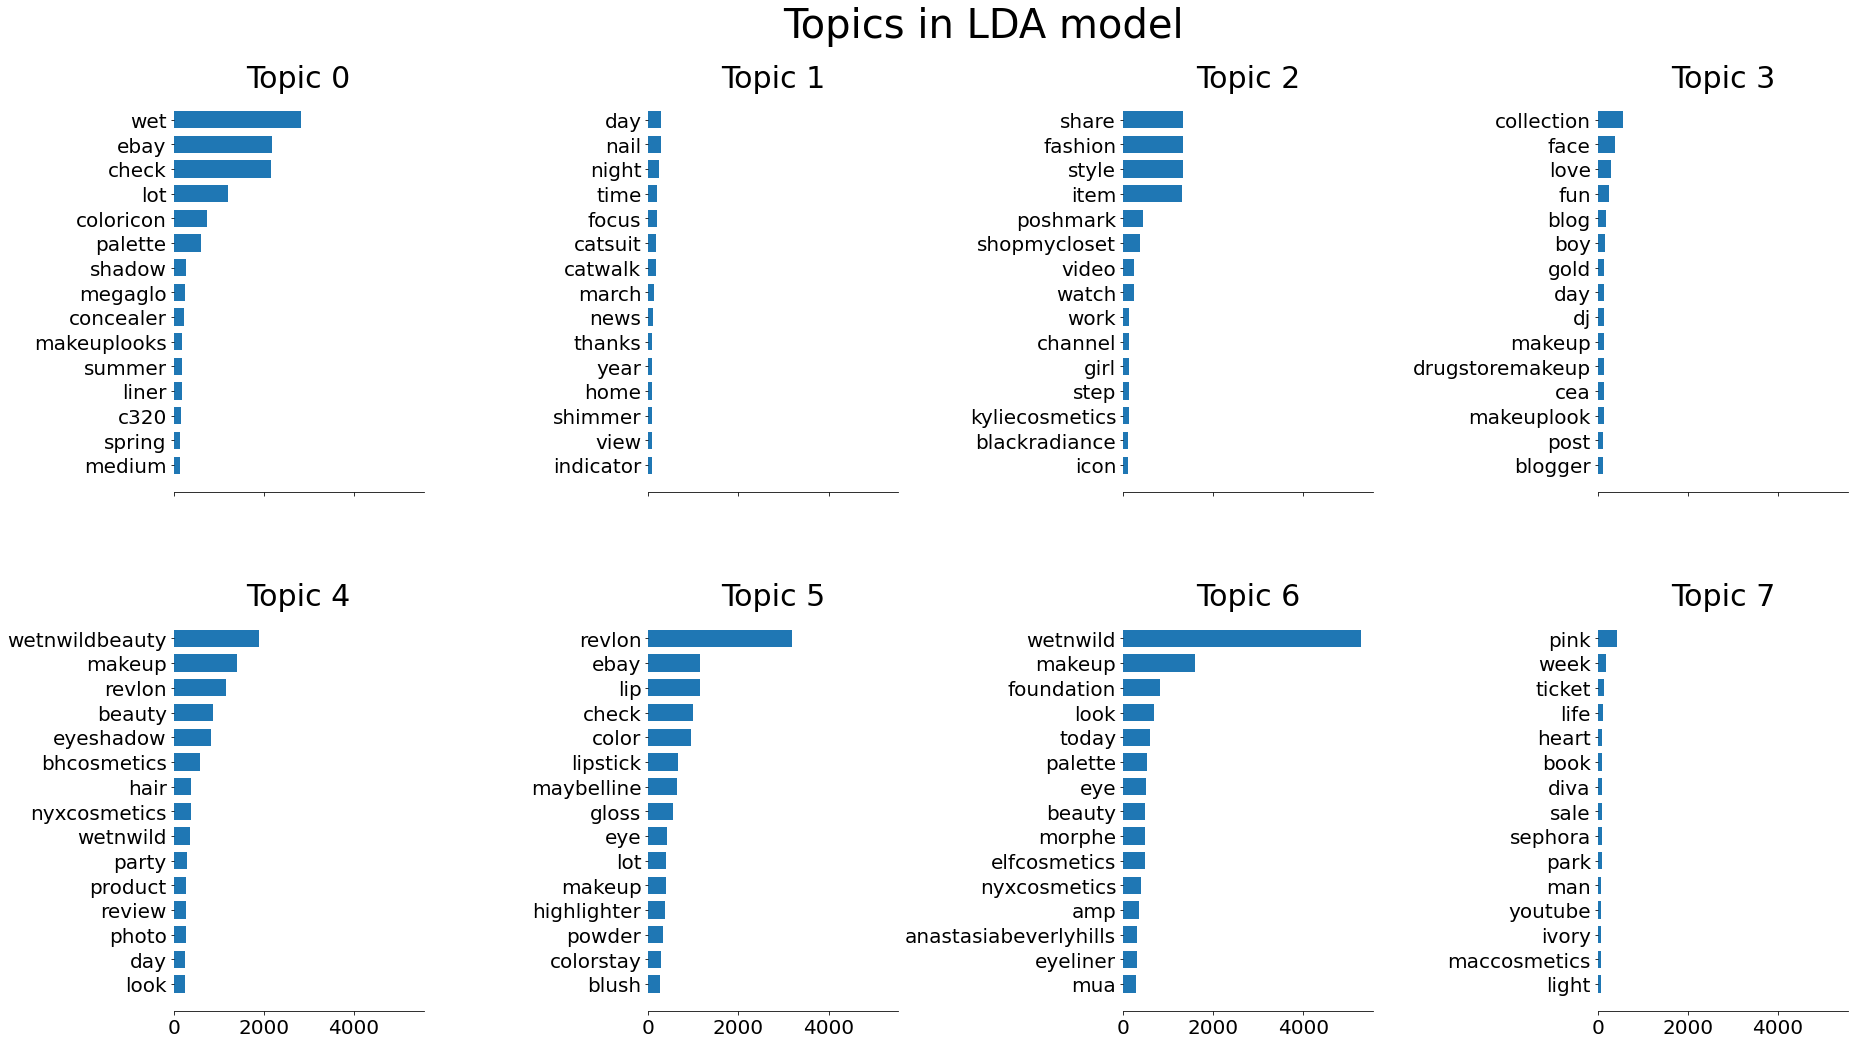

In [17]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2,4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
#     for topic_idx, topic in enumerate(model.components_):
#             print("topic_idx:",topic_idx)
#             print("topic:", topic)
        
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, tf_vectorizer.get_feature_names(), n_top_words, 'Topics in LDA model')